# Examen Modelos Computacionales II
## Claudia Coutiño V.

**Dataset**: Imgs de Brain Tumor

*Objetivo*: Aplicar CNN al dataset

Expectativa:
1. Mantener el accuracy del modelo
2. Mejorar el accuracy con lo explicado en clase (# de capas, # de neuronas, función de activación)
3. Comparar los resultados del modelo CNN con los resultados de los métodos previamente utilizados

In [1]:
# Importar paqueterías
import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

# Configuración inicial
print(f"Versión de TensorFlow: {tf.__version__}")
tf.random.set_seed(42)  # Para reproducibilidad

print("Importaciones Verificadas :)")

C:\Users\clau\anaconda3\envs\tfenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Versión de TensorFlow: 2.19.0
Importaciones Verificadas :)


### TensorFlow para Clasificación de Tumores Cerebrales

In [16]:
# Cargar dataset y preparar datos
ruta_dataset = r"C:\Users\clau\Desktop\Repo-2025\Neurociencias-2025-2\S03_datasets\Brain_tumor\Brain Tumor\Brain Tumor"
ruta_csv = r"C:\Users\clau\Desktop\Repo-2025\Neurociencias-2025-2\S03_datasets\Brain_tumor\Brain Tumor.csv"
df = pd.read_csv(ruta_csv)

In [17]:
df['Image'] = df['Image'].astype(str) + ".jpg" # Agregar extensión a nombres de imagen
df['filepath'] = df['Image'].apply(lambda x: os.path.join(ruta_dataset, x)) # Ruta a cada imagen
df['Class'] = pd.to_numeric(df['Class'], errors='coerce') # Convertir clase a numérico

# Crear dataset TensorFlow
filepaths = df['filepath'].values # Rutas
labels = df['Class'].values # Etiquetas

dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

In [18]:
# Función para cargar y preprocesar imágenes
def load_image(filepath, label):
    # 1. Leer archivo
    image = tf.io.read_file(filepath)
    # 2. Decodificar JPEG
    image = tf.image.decode_jpeg(image, channels=3)
    # 3. Convertir a float32 y normalizar [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 4. Redimensionar
    image = tf.image.resize(image, [128, 128])
    return image, label

# Aplicar la función de carga al dataset
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
# División Entrenamiento/Validación
total = len(filepaths)
train_size = int(0.8 * total) 
train_dataset = (
    dataset.take(train_size)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    dataset.skip(train_size)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

### Modelo CNN

In [20]:
# Generar modelo CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # para que tenga una salida binaria
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\clau\anaconda3\envs\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Utilizando 2 capas convolucionales + pooling, luego capas densas y función de activación sigmoid para binarios.

In [21]:
# Entrenar modelo
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10)

print("Accuracy Final en Validación:", history.history['val_accuracy'][-1])

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 76s 708ms/step - accuracy: 0.7167 - loss: 0.6300 - val_accuracy: 0.6773 - val_loss: 0.8092
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 710ms/step - accuracy: 0.8427 - loss: 0.3704 - val_accuracy: 0.7570 - val_loss: 0.5589
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 68s 697ms/step - accuracy: 0.8583 - loss: 0.3321 - val_accuracy: 0.8393 - val_loss: 0.3649
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 71s 722ms/step - accuracy: 0.9038 - loss: 0.2404 - val_accuracy: 0.8499 - val_loss: 0.3398
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 719ms/step - accuracy: 0.8738 - loss: 0.3099 - val_accuracy: 0.8619 - val_loss: 0.3550
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 68s 696ms/step - accuracy: 0.9296 - loss: 0.1811 - val_accuracy: 0.8327 - val_loss: 0.3409
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 72s 740ms/step - accuracy: 0.9175 - loss: 0.1930 - val_accuracy: 0.8951 - val_loss: 0.2854
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 63s 639ms/step - accuracy: 0.9435 - loss: 0.1539 - val_accu

### Mejorar Modelo

In [22]:
model_mejorado = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Para mejorar generalización
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_mejorado.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

## Agregando más capas convolucionales, normalización por batch

In [23]:
# Verificar Accuracy
history_mejorado = model_mejorado.fit(train_dataset, validation_data=val_dataset, epochs=10)
print("Accuracy final validación modelo mejorado:", history_mejorado.history['val_accuracy'][-1])

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.7806 - loss: 2.5623 - val_accuracy: 0.6587 - val_loss: 4.1613
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8437 - loss: 0.3722 - val_accuracy: 0.6587 - val_loss: 9.7750
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.8529 - loss: 0.3511 - val_accuracy: 0.6587 - val_loss: 8.5372
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8891 - loss: 0.2742 - val_accuracy: 0.6587 - val_loss: 3.3775
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8771 - loss: 0.3080 - val_accuracy: 0.6587 - val_loss: 2.4889
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9056 - loss: 0.2620 - val_accuracy: 0.6999 - val_loss: 0.8402
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8924 - loss: 0.2684 - val_accuracy: 0.8459 - val_loss: 0.3512
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9026 - loss: 0.2453 - val_accuracy: 0.7756 - v

### Visualizar resultados

In [26]:
# Configuración de estilo
print("Estilos disponibles:", plt.style.available)
plt.style.use('dark_background')
palette = plt.get_cmap('Set2')
plt.figure(figsize=(15, 10))

Estilos disponibles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

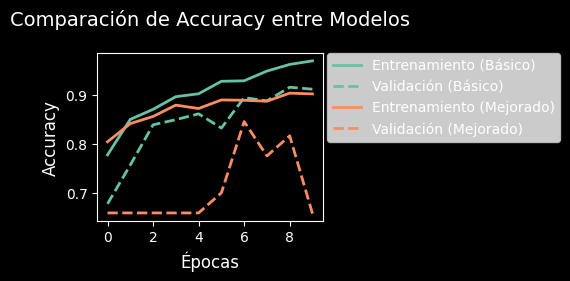

In [28]:
# Gráfico Comparativo de Accuracy (Todos los modelos)
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], color=palette(0), linestyle='-', linewidth=2, 
         label='Entrenamiento (Básico)')
plt.plot(history.history['val_accuracy'], color=palette(0), linestyle='--', linewidth=2,
         label='Validación (Básico)')
plt.plot(history_mejorado.history['accuracy'], color=palette(1), linestyle='-', linewidth=2,
         label='Entrenamiento (Mejorado)')
plt.plot(history_mejorado.history['val_accuracy'], color=palette(1), linestyle='--', linewidth=2,
         label='Validación (Mejorado)')

plt.title('Comparación de Accuracy entre Modelos', fontsize=14, pad=20)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Ajuste de la leyenda
plt.legend(
    frameon=True,
    facecolor='white',
    framealpha=0.8,
    bbox_to_anchor=(1.02, 1),  # Mover fuera del área del gráfico
    loc='upper left',          # Punto de anclaje
    borderaxespad=0.           # Espacio entre leyenda y eje
)

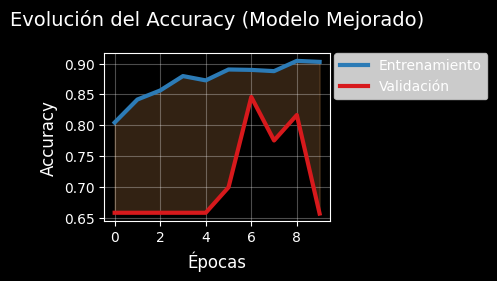

In [29]:
# Detalles del Modelo Mejorado: Accuracy
plt.subplot(2, 2, 2)
plt.plot(history_mejorado.history['accuracy'], color='#2c7bb6', linewidth=3, 
         label='Entrenamiento')
plt.plot(history_mejorado.history['val_accuracy'], color='#d7191c', linewidth=3,
         label='Validación')

plt.title('Evolución del Accuracy (Modelo Mejorado)', fontsize=14, pad=20)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Ajuste de la leyenda
plt.legend(
    frameon=True,
    facecolor='white',
    framealpha=0.8,
    bbox_to_anchor=(1.02, 1),  # Mueve la leyenda fuera del área del gráfico
    loc='upper left',          # Punto de anclaje
    borderaxespad=0.           # Espacio entre leyenda y eje
)
plt.fill_between(range(len(history_mejorado.history['accuracy'])),
                 history_mejorado.history['accuracy'],
                 history_mejorado.history['val_accuracy'],
                 color='#fdae61', alpha=0.2)
plt.grid(True, alpha=0.3)

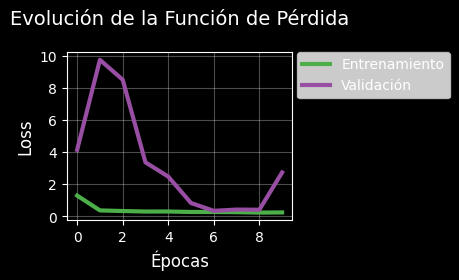

In [30]:
# Detalles del Modelo Mejorado: Loss
plt.subplot(2, 2, 3)
plt.plot(history_mejorado.history['loss'], color='#4daf4a', linewidth=3,
         label='Entrenamiento')
plt.plot(history_mejorado.history['val_loss'], color='#984ea3', linewidth=3,
         label='Validación')

plt.title('Evolución de la Función de Pérdida', fontsize=14, pad=20)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Ajuste de la leyenda
plt.legend(
    frameon=True,
    facecolor='white',
    framealpha=0.8,
    bbox_to_anchor=(1.02, 1),  # Mueve la leyenda fuera del área del gráfico
    loc='upper left',          # Punto de anclaje
    borderaxespad=0.           # Espacio entre leyenda y eje
)
plt.grid(True, alpha=0.3)

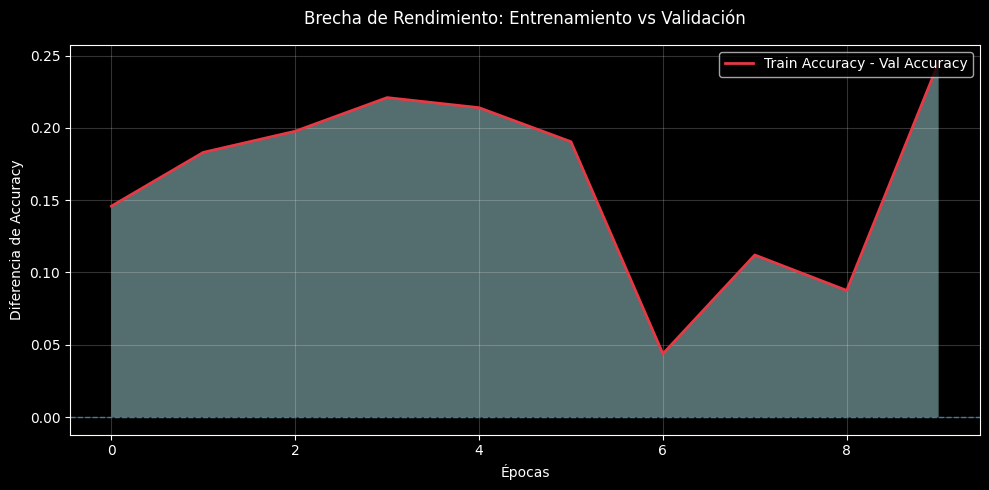

In [34]:
# Gráfico de Brecha entre Train/Val
plt.figure(figsize=(10, 5))
gap = np.array(history_mejorado.history['accuracy']) - np.array(history_mejorado.history['val_accuracy'])

plt.plot(gap, color='#e63946', linewidth=2, label='Train Accuracy - Val Accuracy')
plt.axhline(0, color='#457b9d', linestyle='--', linewidth=1)

# Área positiva y negativa
plt.fill_between(range(len(gap)), gap, 0, where=gap>=0, 
                 facecolor='#a8dadc', alpha=0.5)
plt.fill_between(range(len(gap)), gap, 0, where=gap<=0, 
                 facecolor='#ffddd2', alpha=0.5)

plt.title('Brecha de Rendimiento: Entrenamiento vs Validación', pad=15)
plt.xlabel('Épocas')
plt.ylabel('Diferencia de Accuracy')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### Comparar con Random Forest

In [35]:
# Random Forest
X = df.drop(columns=['Image', 'filepath', 'Class']) # Eliminar columnas no numéricas y etiquetas
y = df['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

acc_rf = accuracy_score(y_val, y_pred)
print("Accuracy Random Forest:", acc_rf)

Accuracy Random Forest: 0.9840637450199203


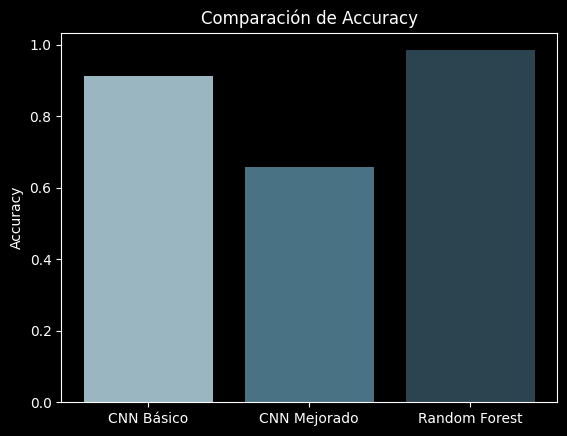

In [40]:
# Comparar Accuracy
colores = ['#9ab6c1', '#497285', '#2b4450']  # Define los colores

plt.bar(['CNN Básico', 'CNN Mejorado', 'Random Forest'],
        [history.history['val_accuracy'][-1],
         history_mejorado.history['val_accuracy'][-1],
         acc_rf],
        color=colores)  # Aplica los colores aquí

plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy')
plt.show()